# CNN
CNN(Convolutional Neural Network, 합성곱 신경망)은 이미지 처리, 비디오 분석, 이미지 분류, 이미지 인식 등 다양한 분야에서 널리 사용되는 딥러닝 알고리즘 중 하나입니다. CNN은 특히 이미지의 공간 정보를 효과적으로 처리할 수 있도록 설계되었습니다. 기본적인 CNN 구조는 여러 개의 층(layers)으로 구성되어 있으며, 주요 구성 요소는 다음과 같습니다.

In [1]:
from tensorflow import keras
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

C:\Users\hanjw\anaconda3\anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


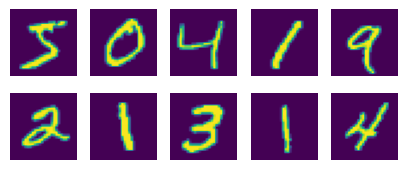

In [2]:
import matplotlib.pyplot as plt

# 2행 5열의 서브플롯 생성
fig, axs = plt.subplots(2, 5, figsize=(5, 2))

# 각 서브플롯에 이미지를 표시
for i in range(2):
    for j in range(5):
        index = i * 5 + j  # 현재 그리드의 인덱스 계산
        axs[i, j].imshow(train_x[index])  # 해당 위치의 서브플롯에 이미지 표시
        axs[i, j].axis('off')  # 축 눈금 숨기기

plt.show()

In [3]:
train_x.shape

(60000, 28, 28)

In [4]:
train_y[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [5]:
train_scaled = train_x.reshape(-1, 1, 28, 28) / 255
test_scaled = test_x.reshape(-1, 1, 28, 28) / 255

In [6]:
class Affine:
    
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

In [7]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx

In [8]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [9]:
class RMSprop:

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [10]:
class AdaGrad:

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [11]:
class Momentum:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

In [12]:
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 

In [13]:
class Nesterov:
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

In [14]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

In [15]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [16]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
            
            
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)# 2차원으로 바꾸어 반환
    return col

In [17]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    return img[:, :, pad:H + pad, pad:W + pad]

In [18]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        # 중간 데이터（backward 시 사용）
        self.x = None
        self.col = None
        self.col_W = None
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        self.x = x
        self.col = col
        self.col_W = col_W
        return out
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return dx

In [20]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.x = None
        self.arg_max = None
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        self.arg_max = arg_max
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        return dx

In [23]:
class Trainer:
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01},
                 evaluate_sample_num_per_epoch=None, verbose=True):
        
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch
        
        # optimzer
        
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []
    
    def train_step(self):
        
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: 
            print("train loss:" + str(loss))
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)
            if self.verbose: print("epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1
    def train(self):
        for i in range(self.max_iter):
            self.train_step()
        test_acc = self.network.accuracy(self.x_test, self.t_test)
        if self.verbose:
            print("Final Test Accuracy")
            print("test acc:" + str(test_acc))

In [28]:
class ConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)
        return acc / x.shape[0]
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads
    
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
            
    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
            
        for key, val in params.items():
            self.params[key] = val
            
        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [31]:
class Relu:
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

# 무지성 아담

In [35]:
import numpy as np
from collections import OrderedDict # 순서가 있는 딕셔너리

(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

train_scaled = train_x.reshape(-1,1,28,28)/255
test_scaled = test_x.reshape(-1,1,28,28)/255

net = ConvNet(input_dim=(1,28,28))

trainer = Trainer(net, train_scaled, train_y, test_scaled, test_y, epochs= 10, mini_batch_size = 100, optimizer= "Adam", 
                  optimizer_param={"lr":0.01})

trainer.train()

train loss:2.260967045489168
epoch:1, train acc:0.10218333333333333, test acc:0.101 ===
train loss:2.151248811980249
train loss:1.9802502620333047
train loss:1.674143092873105
train loss:1.3823010277175412
train loss:1.3135975925104415
train loss:0.9938284158139195
train loss:1.0006987852950642
train loss:0.9217491040675072
train loss:0.9572273255314013
train loss:0.9568945031121504
train loss:0.8306772293259296
train loss:0.7858682493108172
train loss:0.7312785207846979
train loss:0.5987000127117191
train loss:0.754699143963161
train loss:0.4174378747257715
train loss:0.604815205423305
train loss:0.43822591064169186
train loss:0.4530920587986876
train loss:0.4893034174035493
train loss:0.4009352856423002
train loss:0.548170315170409
train loss:0.43808908228695925
train loss:0.33144057692445217
train loss:0.5408690914003877
train loss:0.19435530181319596
train loss:0.2304802116157132
train loss:0.29749861382293935
train loss:0.2955119980500268
train loss:0.34264080027455607
train loss:

train loss:0.04787605999816806
train loss:0.04219727076431469
train loss:0.12642603863688182
train loss:0.05072812603297689
train loss:0.033811997526081876
train loss:0.02937069008446894
train loss:0.039774590604466066
train loss:0.024774753215185786
train loss:0.060928894023168756
train loss:0.08650005314934738
train loss:0.0505868084297714
train loss:0.04497838342697016
train loss:0.0646589906315284
train loss:0.07068154453712289
train loss:0.0453162781574315
train loss:0.06423045004206988
train loss:0.05950821058469142
train loss:0.028692985600316908
train loss:0.021340764174821125
train loss:0.04506925878970359
train loss:0.020214684095861243
train loss:0.058491282047150046
train loss:0.02165882210052995
train loss:0.02124951473556545
train loss:0.028020775106038794
train loss:0.011249755901093086
train loss:0.054188518584584774
train loss:0.04783967372237833
train loss:0.08263560937101999
train loss:0.058030486885674464
train loss:0.0225384248624407
train loss:0.11898083026577046


train loss:0.012584324981424911
train loss:0.1582804716722001
train loss:0.10749418981775259
train loss:0.027609593538788068
train loss:0.06298905994288763
train loss:0.02000205144029239
train loss:0.027506493323358434
train loss:0.03136661800330458
train loss:0.052888906870749104
train loss:0.07734995296208798
train loss:0.05040644356384548
train loss:0.005967599883954459
train loss:0.025329433284951564
train loss:0.09659683009302339
train loss:0.06674924332863207
train loss:0.12148329670336423
train loss:0.027933228848203883
train loss:0.02413689554391127
train loss:0.05738158757697545
train loss:0.01401236161593768
train loss:0.015243327453492037
train loss:0.013830118378384432
train loss:0.08320520453670126
train loss:0.018673985759844493
train loss:0.03708206252634465
train loss:0.016481257294759136
train loss:0.03982574917835785
train loss:0.037878471054327484
train loss:0.054950403322794196
train loss:0.010609651318674241
train loss:0.03136065195743631
train loss:0.0711366889598

train loss:0.029991554611987846
train loss:0.024303972983159276
train loss:0.02734857684646201
train loss:0.024153859599369266
train loss:0.032212456925871685
train loss:0.0016839806905830446
train loss:0.0047778175992687095
train loss:0.01401868673531026
train loss:0.014397199535156825
train loss:0.012474973478119959
train loss:0.046065623276175575
train loss:0.06478345100000302
train loss:0.08166572657753367
train loss:0.0595557516829687
train loss:0.02054707709673802
train loss:0.008231296387225123
train loss:0.031378180419480546
train loss:0.021556124516309755
train loss:0.16025313450101936
train loss:0.04511141442643814
train loss:0.0977877565965299
train loss:0.0793930003357132
train loss:0.010545441151752311
train loss:0.030897332567483823
train loss:0.12227026133171295
train loss:0.06699677401370135
train loss:0.058005128250335034
train loss:0.035280102882849024
train loss:0.015809073050249735
train loss:0.03167043306428396
train loss:0.038031925574717344
train loss:0.040058917

train loss:0.014341647915732923
train loss:0.01083879017830295
train loss:0.0171813574917614
train loss:0.002657302773304827
train loss:0.005495685624134876
train loss:0.020908714258926753
train loss:0.02678330757089146
train loss:0.003100310015628714
train loss:0.019711034293902165
train loss:0.007189082771247861
train loss:0.10117613523810429
train loss:0.0613386163822597
train loss:0.004777689920644329
train loss:0.024531416130120408
train loss:0.007351811208336643
train loss:0.005758885124691361
train loss:0.01106294817522329
train loss:0.0029479353962975825
train loss:0.009160564722751167
train loss:0.008916844937342277
train loss:0.017389251804789407
train loss:0.07658511447363964
train loss:0.016040181577029113
train loss:0.036652167828529376
train loss:0.0010573166542659264
train loss:0.002427213623224089
train loss:0.005961459175196538
train loss:0.01906660000245694
train loss:0.011641357737151168
train loss:0.037926524250637444
train loss:0.024210179611644206
train loss:0.058

train loss:0.01734744676230532
train loss:0.020273208509216403
train loss:0.020526063458521294
train loss:0.008640435855234002
train loss:0.016946620590820718
train loss:0.009397108623626966
train loss:0.013340728112127314
train loss:0.019455446472891488
train loss:0.02041464355335854
train loss:0.00859391899455845
train loss:0.008746771861168212
train loss:0.038195793094921014
train loss:0.006041071295715759
train loss:0.04496761429540189
train loss:0.00914609456228122
train loss:0.028458952721878827
train loss:0.016513806812739906
train loss:0.023219028460317332
train loss:0.001697425938195626
train loss:0.016767554925718325
train loss:0.019113233766045158
train loss:0.0253649993212349
train loss:0.011959155435108015
train loss:0.005896068153808248
train loss:0.024903775372711285
train loss:0.01549247511275742
train loss:0.08903143558619699
train loss:0.12289931665387034
train loss:0.006014286923236673
train loss:0.004607867452730735
train loss:0.009913164082577043
train loss:0.01325

train loss:0.030160575608379633
train loss:0.0042117206884373344
train loss:0.0002289263338345795
train loss:0.007929870595452455
train loss:0.062253551798914335
train loss:0.03440914672799412
train loss:0.04722847772839115
train loss:0.012907677183519888
train loss:0.012567308895381865
train loss:0.0038850910509181085
train loss:0.009869428433902509
train loss:0.004112183277594726
train loss:0.014193943384306056
train loss:0.01381942980452584
train loss:0.05346960100385534
train loss:0.005385921686751377
train loss:0.008351491321974882
train loss:0.02342767609762606
train loss:0.12055410972415989
train loss:0.007174212752262075
train loss:0.015126349469912702
train loss:0.006164783583047242
train loss:0.010820702299306451
train loss:0.01210884910107303
train loss:0.022687554214688245
train loss:0.0016381133073314071
train loss:0.011182378795367829
train loss:0.010685803381059766
train loss:0.03268453728467306
train loss:0.03621267434681208
train loss:0.028472708056445126
train loss:0.

KeyboardInterrupt: 

In [36]:
# 원본 리스트
my_list = ['apple', 'banana', 'cherry', 'date']
# 특정 인덱스 기준으로 정렬 (예: 인덱스 2의 값 기준)
index_to_sort = 2
sorted_list = sorted(my_list, key=lambda x: x[index_to_sort])
print(sorted_list)

['cherry', 'banana', 'apple', 'date']
